In [1]:
import tensorflow as tf

def disp_dataset(ds, limit=None, print_elements=True):
    count = 0

    for x in ds:
        count += 1
        if print_elements:
            print(x)
        if limit is not None and count >= limit:
            break
    print(f"Count:{count}")


In [2]:
original = tf.data.Dataset.range(10)

def stack_elements(ds):
    stacked = tf.stack([x for x in ds], axis=0)
    return stacked


# Chaque élément du dataset est un tenseur, et on a 20 éléments car on répète le dataset 2 fois.
repeated = original.repeat(2)
# disp_dataset(repeated)

# Les éléments sont mélangés. On a toujours 20 éléments. 
shuffled = repeated.shuffle(buffer_size=5)
# disp_dataset(shuffled)

# Ici, chaque répétition ne sera pas mélangé avec son prochain.
# disp_dataset(original.shuffle(buffer_size=5).repeat(2))

# On a plus que 4 itérations, et chaque élément est un tenseur à plusieurs éléments
batched = shuffled.batch(5)
print(f"Iterating over batched")
disp_dataset(batched)
print(f"Stacking elements of batched")
print(stack_elements(batched))

Iterating over batched
tf.Tensor([4 5 1 0 8], shape=(5,), dtype=int64)
tf.Tensor([9 0 3 6 1], shape=(5,), dtype=int64)
tf.Tensor([3 2 6 5 2], shape=(5,), dtype=int64)
tf.Tensor([7 4 9 8 7], shape=(5,), dtype=int64)
Count:4
Stacking elements of batched
tf.Tensor(
[[1 5 3 6 4]
 [0 0 8 2 9]
 [2 7 3 1 8]
 [9 7 4 6 5]], shape=(4, 5), dtype=int64)


In [26]:
disp_dataset(batched)
disp_dataset(batched)

tf.Tensor([1 5 6 3 8], shape=(5,), dtype=int64)
tf.Tensor([9 4 2 7 1], shape=(5,), dtype=int64)
tf.Tensor([0 0 5 7 4], shape=(5,), dtype=int64)
tf.Tensor([9 2 8 3 6], shape=(5,), dtype=int64)
Count:4
tf.Tensor([2 1 6 3 5], shape=(5,), dtype=int64)
tf.Tensor([4 9 8 0 2], shape=(5,), dtype=int64)
tf.Tensor([1 3 5 7 0], shape=(5,), dtype=int64)
tf.Tensor([7 8 6 4 9], shape=(5,), dtype=int64)
Count:4


In [5]:
n_readers = 2

# Chaque fichier a 20641 éléments. Pour 4 fichiers, on a 82564 éléments. Les 4 fichiers ont les mêmes données.

filepaths = ["./housing_0.csv", "./housing_1.csv", "./housing_2.csv", "./housing_3.csv"]
filepath_dataset = tf.data.Dataset.list_files(filepaths, seed=42)

def lambda_f(filepath):
    print("lambda_f is called")
    return tf.data.TextLineDataset(filepath).skip(1)

dataset = filepath_dataset.interleave(
    lambda_f,
    cycle_length=n_readers + 1
)

# Nous voyons que pour pour n_readers itérations, càd limit = n_readers,  on récupère exactement n_readers même lignes
# A chaque itération, il va aller chercher la prochaine ligne dans le prochain fichier. Une fois qu'il a cycler sur les n_readers fichiers, il prendra la prochaine ligne du 1er des fichiers.

# Une fois tous les éléments des n_readers fichiers lus, il passera aux fichiers suivants.

disp_dataset(dataset, limit=6)

lambda_f is called
tf.Tensor(b'-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY', shape=(), dtype=string)
tf.Tensor(b'-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY', shape=(), dtype=string)
tf.Tensor(b'-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY', shape=(), dtype=string)
tf.Tensor(b'-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY', shape=(), dtype=string)
tf.Tensor(b'-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY', shape=(), dtype=string)
tf.Tensor(b'-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY', shape=(), dtype=string)
Count:6


In [7]:
n_inputs = 9
def preprocess(line):
    # defs est juste là pour indiquer les types des données. c'est un template
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.string)]
    fields = tf.io.decode_csv(line, record_defaults=defs)

    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])

    return x, y

disp_dataset(dataset.take(1).map(preprocess, num_parallel_calls=2), print_elements=True)
preprocessed_dataset = dataset.map(preprocess)

(<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-1.2223e+02,  3.7880e+01,  4.1000e+01,  8.8000e+02,  1.2900e+02,
        3.2200e+02,  1.2600e+02,  8.3252e+00,  4.5260e+05], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'NEAR BAY'], dtype=object)>)
Count:1


# TFRecords

In [24]:
# Sauvegarde d'un des fichiers housing.csv en .tfrecord

path = "./tfrecord/"

# writer = tf.io.TFRecordWriter(path + "housing_full.tfrecord")
# writer.write(dataset)

In [2]:
import numpy as np 
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

feature = _float_feature(np.exp(1))

feature.SerializeToString()

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



b'\x12\x06\n\x04T\xf8-@'

In [3]:
def serialize_example(
    longitude,
    latitude,
    housing_median_age,
    total_rooms,
    total_bedrooms,
    population,
    households,
    median_income,
    median_house_value,
    ocean_proximity,
):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
    'longitude': _float_feature(longitude),
    'latitude': _float_feature(latitude),
    'housing_median_age': _float_feature(housing_median_age),
    'total_rooms': _float_feature(total_rooms),
    'total_bedrooms': _float_feature(total_bedrooms),
    'population': _float_feature(population),
    'households': _float_feature(households),
    'median_income': _float_feature(median_income),
    'median_house_value': _float_feature(median_house_value),
    'ocean_proximity': _bytes_feature(ocean_proximity),
  }

  # Create a Features message using tf.train.Example.
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

one_observation = serialize_example(-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,b'NEAR BAY')
print(f"serialized_example: {one_observation}")

def deserialize(serialized_line):
    return tf.train.Example.FromString(serialized_line)
    
print(f"unserialized: {deserialize(one_observation)}")

serialized_example: b'\n\x8e\x02\n\x1f\n\x0focean_proximity\x12\x0c\n\n\n\x08NEAR BAY\n\x16\n\nhouseholds\x12\x08\x12\x06\n\x04\x00\x00\xfcB\n\x14\n\x08latitude\x12\x08\x12\x06\n\x04\x1f\x85\x17B\n\x19\n\rmedian_income\x12\x08\x12\x06\n\x04\x054\x05A\n\x1e\n\x12housing_median_age\x12\x08\x12\x06\n\x04\x00\x00$B\n\x15\n\tlongitude\x12\x08\x12\x06\n\x04\xc3u\xf4\xc2\n\x1e\n\x12median_house_value\x12\x08\x12\x06\n\x04\x00\xff\xdcH\n\x1a\n\x0etotal_bedrooms\x12\x08\x12\x06\n\x04\x00\x00\x01C\n\x16\n\npopulation\x12\x08\x12\x06\n\x04\x00\x00\xa1C\n\x17\n\x0btotal_rooms\x12\x08\x12\x06\n\x04\x00\x00\\D'
unserialized: features {
  feature {
    key: "households"
    value {
      float_list {
        value: 126.0
      }
    }
  }
  feature {
    key: "housing_median_age"
    value {
      float_list {
        value: 41.0
      }
    }
  }
  feature {
    key: "latitude"
    value {
      float_list {
        value: 37.880001068115234
      }
    }
  }
  feature {
    key: "longitude"
    val

In [80]:
# Saving dataset of CSV file into a TFRecord
path_to_save = "./tfrecord/housing_first100.tfrecord"
def pipeline_save_dataset_tf_record(dataset, path_to_save = path_to_save):
    # Méthode 1: 
    # on preprocess le csv pour décoder les bytes que l'on reçoit.
    # puis, pour chaque ligne du csv, on décode récupère les valeurs de chaque variable,
    # et on map une feature à ces valeurs
    with tf.io.TFRecordWriter(path_to_save) as file_to_save:
        dataset_processed = dataset.take(100).map(preprocess, num_parallel_calls = 6)
        for element in dataset_processed:
            x, y = element
            a,b,c,d,e,f,g,h,i = tf.unstack(x)
            # y = y.numpy()[0] # on récupère la valeur en byte du string, qui était stockée dans un array de 1 élément
            y = tf.io.serialize_tensor(y)
            my_example = serialize_example(a,b,c,d,e,f,g,h,i, y)

            file_to_save.write(my_example)

pipeline_save_dataset_tf_record(dataset.take(100))


In [82]:
# Reading the tfrecord file
tfrecord_dataset = tf.data.TFRecordDataset([path_to_save])

feature_description = {
    'longitude': tf.io.FixedLenFeature([], tf.float32),
    'latitude': tf.io.FixedLenFeature([], tf.float32),
    'housing_median_age': tf.io.FixedLenFeature([], tf.float32),
    'total_rooms': tf.io.FixedLenFeature([], tf.float32),
    'total_bedrooms': tf.io.FixedLenFeature([], tf.float32),
    'population': tf.io.FixedLenFeature([], tf.float32),
    'households': tf.io.FixedLenFeature([], tf.float32),
    'median_income': tf.io.FixedLenFeature([], tf.float32),
    'median_house_value': tf.io.FixedLenFeature([], tf.float32),
    'ocean_proximity': tf.io.FixedLenFeature([], tf.string),
}

def read_tf_record_dataset(tfrecord_dataset, batch=None):
    if batch is None:
        dictionaries_dataset_of_features = tfrecord_dataset.map(lambda line: tf.io.parse_single_example(line, feature_description))
    else:
        dictionaries_dataset_of_features = tfrecord_dataset.batch(batch).map(lambda line: tf.io.parse_example(line, feature_description))

    def dictionnaire_to_tensors(dictionnary):
        longitude = dictionnary['longitude']
        latitude = dictionnary['latitude']
        housing_median_age = dictionnary['housing_median_age']
        total_rooms = dictionnary['total_rooms']
        total_bedrooms = dictionnary['total_bedrooms']
        population = dictionnary['population']
        households = dictionnary['households']
        median_income = dictionnary['median_income']
        median_house_value = dictionnary['median_house_value']
        ocean_proximity = dictionnary['ocean_proximity']

        X = tf.stack([longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value], axis = batch is not None)
        y = tf.stack([ocean_proximity])
        return X, y

    return dictionaries_dataset_of_features.map(dictionnaire_to_tensors)

# disp_dataset(tfrecord_dataset.take(1).map(lambda line: tf.io.parse_single_example(line, feature_description)))
disp_dataset(read_tf_record_dataset(tfrecord_dataset.take(10), batch=5))

(<tf.Tensor: shape=(5, 9), dtype=float32, numpy=
array([[-1.2223e+02,  3.7880e+01,  4.1000e+01,  8.8000e+02,  1.2900e+02,
         3.2200e+02,  1.2600e+02,  8.3252e+00,  4.5260e+05],
       [-1.2223e+02,  3.7880e+01,  4.1000e+01,  8.8000e+02,  1.2900e+02,
         3.2200e+02,  1.2600e+02,  8.3252e+00,  4.5260e+05],
       [-1.2223e+02,  3.7880e+01,  4.1000e+01,  8.8000e+02,  1.2900e+02,
         3.2200e+02,  1.2600e+02,  8.3252e+00,  4.5260e+05],
       [-1.2222e+02,  3.7860e+01,  2.1000e+01,  7.0990e+03,  1.1060e+03,
         2.4010e+03,  1.1380e+03,  8.3014e+00,  3.5850e+05],
       [-1.2222e+02,  3.7860e+01,  2.1000e+01,  7.0990e+03,  1.1060e+03,
         2.4010e+03,  1.1380e+03,  8.3014e+00,  3.5850e+05]],
      dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=string, numpy=
array([[b'\x08\x07\x12\x04\x12\x02\x08\x01B\x08NEAR BAY',
        b'\x08\x07\x12\x04\x12\x02\x08\x01B\x08NEAR BAY',
        b'\x08\x07\x12\x04\x12\x02\x08\x01B\x08NEAR BAY',
        b'\x08\x07\x12\x04\x12\x02\x

En résumé, pour chaque ligne du dataset:
 - récupérer les valeurs des variables
 - Créer un dictionnaire de Feature, qui contiendra ces valeurs. Une Feature pour chaque variable.
 - Wrapper ça dans un Example, et serializer l'objet Example.
 - Ecrire l'objet sérializé dans notre fichier.

Lecture:
- Lire le tfrecord
- Pour chaque ligne du tfrecord, qui est une ligne de bytes, deserializer avec "tf.io.parse_single_example", où on doit fournir un dictionnaire de description de features

In [30]:
# Testing the Normalization layer

from tensorflow.keras.layers.experimental.preprocessing import Normalization

def echantillon(dataset, size=100):
    return dataset.take(size)

X_train = preprocessed_dataset.map(lambda X,y: X)
normalizer = Normalization()
normalizer.adapt(echantillon(X_train))

normalized_ds = normalizer(tf.stack([x for x in X_train], axis=0))
disp_dataset(normalized_ds, limit = 1)

tf.Tensor(
[-0.324701   -0.32238835 -0.3223433  -0.31022465 -0.3210722  -0.31828448
 -0.32111552 -0.32281524  6.214488  ], shape=(9,), dtype=float32)
Count:1


In [39]:
# Testing the one-hot encoding

vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

y_train = preprocessed_dataset.map(lambda x,y:y)
y_train_indices = y_train.map(lambda y: table.lookup(y))
y_train_categorical = y_train_indices.map(lambda y: tf.one_hot(y, depth=len(vocab) + num_oov_buckets))
disp_dataset(y_train_categorical, limit=2)
# table.lookup(y_train.take(2))


tf.Tensor([[0. 0. 0. 1. 0. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 1. 0. 0. 0.]], shape=(1, 7), dtype=float32)
Count:2


In [3]:
# Exemple de pipeline entière. Entièrement avec l'API tf.Data

filepath = "housing_0.csv"
raw_dataset = tf.data.TextLineDataset(filepath).skip(1)

def decode_csv(line):
    n_inputs = 9
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.string)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    
    x = tf.stack(fields[:-2])
    categories = fields[-1:][0]

    # categories = table.lookup(categories)
    # categories = tf.one_hot(categories, depth=len(vocab) + num_oov_buckets)
    # x = tf.concat([x, categories], axis = 0)

    y = tf.stack(fields[-2:-1])

    return x, categories, y

def string_to_categorical(string):
    category = table.lookup(string)
    category = tf.one_hot(category, depth=len(vocab) + num_oov_buckets)
    # x = tf.concat([x, category], axis = 0)
    return category


In [7]:
dataset = raw_dataset.map(decode_csv, num_parallel_calls=5)
dataset = dataset.shuffle(10000)

test_set = dataset.take(2000)
train_set = dataset.skip(2000)
valid_set = train_set.take(2000)
train_set = train_set.skip(2000)


def batch_sets(list_ds):
    my_list = []
    for x in list_ds:
        new_ds = x.batch(32).map(lambda x,c,y: ((x,c),y), num_parallel_calls=5).prefetch(1)
        my_list.append(new_ds)
    return my_list

[test_set, train_set, valid_set] = batch_sets([test_set, train_set, valid_set])

vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

def adapt_Normalizer(normalizer, dataset, size = 1000):
    X_train = dataset.take(size).map(lambda X,y: X[0])
    normalizer.adapt(X_train)

normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
adapt_Normalizer(normalizer, train_set.take(1000))



In [92]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model

regular_inputs = tf.keras.layers.Input(shape=8)
normalized_inputs = normalizer(regular_inputs)

categories_inputs = tf.keras.layers.Input(shape="", dtype=tf.string)
categorical_inputs = tf.keras.layers.Lambda(lambda category: string_to_categorical(category))(categories_inputs)

concatenated_inputs = tf.keras.layers.concatenate([normalized_inputs, categorical_inputs])

seq = Sequential()
seq.add(Dense(100, activation="elu", kernel_initializer="he_normal"))
seq.add(BatchNormalization())
seq.add(Dense(100, activation="elu", kernel_initializer="he_normal"))
seq.add(BatchNormalization())
seq.add(Dense(1))

seq = seq(concatenated_inputs)

full_model = tf.keras.Model(inputs=[regular_inputs, categories_inputs], outputs=[seq])
full_model.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=tf.keras.optimizers.Nadam(learning_rate=1))

full_model.summary()
full_model.fit(train_set, epochs=10, validation_data=valid_set)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 8)            17          input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 7)            0           input_6[0][0]                    
____________________________________________________________________________________________

In [15]:
# Example de pipeline sans utiliser l'api Data
import pandas as pd
csv_ds = pd.read_csv('./housing_0.csv') 

In [88]:
from sklearn.preprocessing import StandardScaler

y = csv_ds["median_house_value"]
X = pd.DataFrame.copy(csv_ds)
del X["median_house_value"]
del X["ocean_proximity"]

x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

# y_scaler = StandardScaler()
# y = y_scaler.fit_transform(y.to_numpy().reshape(-1,1))

ocean_tensor = table.lookup(tf.constant(csv_ds["ocean_proximity"]))
ocean_tensor = tf.one_hot(ocean_tensor, depth=len(vocab) + num_oov_buckets)

X = tf.constant(X, dtype=tf.float32)
X = tf.concat([X, ocean_tensor], axis = 1).numpy()
y = tf.constant(y).numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [91]:
import os 

def create_model(lr=1e-5):
    seq = Sequential()
    seq.add(Dense(100, activation="elu", kernel_initializer="he_normal", input_shape=[15]))
    seq.add(BatchNormalization())
    seq.add(Dense(100, activation="elu", kernel_initializer="he_normal"))
    seq.add(BatchNormalization())
    seq.add(Dense(1))

    seq.compile(
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
        optimizer=tf.keras.optimizers.Nadam(learning_rate=lr)
    )
    seq.summary()
    return seq

for lr in [1]:
    csv_model = create_model(lr=lr)

    run_logdir = os.path.join(os.curdir, "tsboard_logs/csvmodel/", f"csv_model_lr={lr}")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
    csv_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb])

# En fin de compte, on trouve le même comportement d'entrainement qu'avec notre réseau utilisant l'api Data

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 100)               1600      
_________________________________________________________________
batch_normalization_54 (Batc (None, 100)               400       
_________________________________________________________________
dense_82 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_55 (Batc (None, 100)               400       
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 101       
Total params: 12,601
Trainable params: 12,201
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
523/523 [==============================] - 3s 4ms/step - loss: 13234468945.0992 - root_mean_squared_er

In [99]:
import numpy as np
aa = np.array([[1,2,3]])
yy = [1]

tt = tf.data.Dataset.from_tensor_slices((aa, yy))
tt

ValueError: Value tf.Tensor(1, shape=(), dtype=int32) has insufficient rank for batching.

[[ 2.12963148]
 [ 1.31415614]
 [ 1.25869341]
 ...
 [-0.99274649]
 [-1.05860847]
 [-1.01787803]]


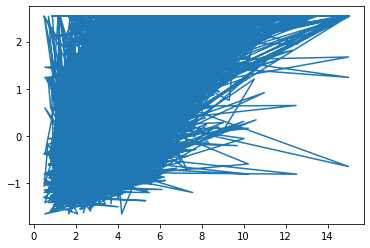

In [84]:
import matplotlib.pyplot as plt
print(y)

plt.figure()
plt.plot(csv_ds["median_income"], y)


# Exercice Movie